<a href="https://colab.research.google.com/github/srilamaiti/spring_2023_w266_final_project_heesuk_iris_srila/blob/main/srila/concat_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install transformers --q

In [6]:
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import tensorflow as tf
import os
import re
import copy

import math
from typing import Optional
import transformers


import torch
import torch.utils.checkpoint as checkpoint
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, AdamW, DataCollatorWithPadding
from tensorflow.keras.layers import GlobalAveragePooling1D

import pickle
import re
from transformers import TrainingArguments, AutoConfig, AutoModelForTokenClassification, DataCollatorForTokenClassification

In [7]:
df = pd.read_csv('train.csv')
df['full_text'] = df["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex = True)

label_cols = df.columns[2:]
pred_col_list = ['transformed_pred_' + col for col in label_cols]

orig_df = copy.deepcopy(df)
split = (0.8, 0.2)
splits = np.multiply(len(orig_df), split).astype(int)
df_train, df_test = orig_df[ : splits[0]], orig_df[splits[0] : ]
y_test = np.array(df_test[label_cols], dtype = "float32")


orig_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal If u change the school policy...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [8]:
MAX_LEN = 128

learning_rate = 1e-5
dropout = .1
epochs = 1
batch_size = 4

In [9]:
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis = 1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis = -1, keepdims = True)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFR

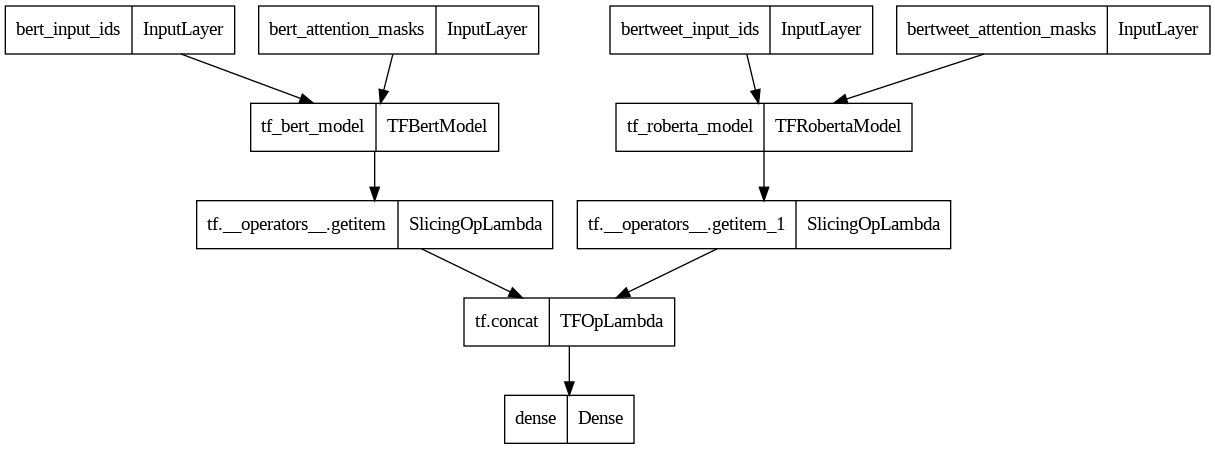

In [10]:
from transformers import RobertaTokenizer, TFRobertaModel
from transformers import TFBertModel, BertTokenizer
from transformers import TFAutoModel, AutoModel, AutoTokenizer

ROBERTA_MODEL_CHKPT = "roberta-base"
BERT_MODEL_CHKPT = "bert-base-cased"
BERTWEET_MODEL_CHKPT = "vinai/bertweet-base"

bert_model = TFBertModel.from_pretrained(BERT_MODEL_CHKPT)  
bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_CHKPT)

#roberta_model = TFBertModel.from_pretrained(ROBERTA_MODEL_CHKPT)  
#roberta_tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_MODEL_CHKPT)

bertweet_model = TFAutoModel.from_pretrained(BERTWEET_MODEL_CHKPT)
bertweet_tokenizer = AutoTokenizer.from_pretrained(BERTWEET_MODEL_CHKPT)

bert_input_ids = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'bert_input_ids')
bert_attention_masks = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'bert_attention_masks')

#roberta_input_ids = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'roberta_input_ids')
#roberta_attention_masks = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'roberta_attention_masks')

bertweet_input_ids = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'bertweet_input_ids')
bertweet_attention_masks = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'bertweet_attention_masks')

pretrained_bert_transformer = bert_model([bert_input_ids, bert_attention_masks])
#pretrained_roberta_transformer = roberta_model([roberta_input_ids, roberta_attention_masks])
pretrained_bertweet_transformer = bertweet_model([bertweet_input_ids, bertweet_attention_masks])

cls_token_bert = pretrained_bert_transformer[0][:, 0, :]
#cls_token_roberta = pretrained_roberta_transformer[0][:, 0, :]
cls_token_bertweet = pretrained_bertweet_transformer[0][:, 0, :]

cls_token_concatenated = tf.concat([cls_token_bert, 
                                    #cls_token_roberta, 
                                    cls_token_bertweet
                                   ], 
                                   1
                                  )

output = tf.keras.layers.Dense(6)(cls_token_concatenated)
concat_model = tf.keras.models.Model(inputs = [bert_input_ids, bert_attention_masks, 
                                               #roberta_input_ids, roberta_attention_masks, 
                                               bertweet_input_ids, bertweet_attention_masks], outputs = output)
concat_model.compile(tf.keras.optimizers.Adam(learning_rate), loss = MCRMSE, metrics = MCRMSE)

tf.keras.utils.plot_model(concat_model, 
                              #to_file='model_structure.png', 
                              #show_shapes = True,
                              show_layer_names = True)

In [11]:
def text_encode(texts, tokenizer_list, max_len):
    bert_input_ids = []
    bert_attention_masks = []

    bertweet_input_ids = []
    bertweet_attention_masks = []

    bert_tokenizer = tokenizer_list[0]
    bertweet_tokenizer = tokenizer_list[1]

    for text in texts:
        bert_tokens = bert_tokenizer.batch_encode_plus(text,
                                                  padding='max_length',
                                                  max_length=max_len, 
                                                  add_special_tokens = True,
                                                  return_attention_mask=True,
                                                  return_tensors="tf",
                                                  truncation=True)
        bert_input_ids.append(bert_tokens['input_ids'])
        bert_attention_masks.append(bert_tokens['attention_mask'])

        bertweet_tokens = bertweet_tokenizer.batch_encode_plus(text,
                                                  padding='max_length',
                                                  max_length=max_len, 
                                                  add_special_tokens = True,
                                                  return_attention_mask=True,
                                                  return_tensors="tf",
                                                  truncation=True)
        bertweet_input_ids.append(bertweet_tokens['input_ids'])
        bertweet_attention_masks.append(bertweet_tokens['attention_mask'])

    print(len(bert_input_ids), len(bertweet_input_ids), len(bert_attention_masks), len(bertweet_attention_masks))
    return [bert_input_ids, bert_attention_masks, bertweet_input_ids, bertweet_attention_masks]


In [12]:
class EssayDataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self,
                 tokenizer_list,
                 df,
                 max_len,
                 batch_size=4,
                 shuffle=True):
        
        self.tokenizer_list = tokenizer_list
        self.bert_tokenizer = self.tokenizer_list[0]
        self.bertweet_tokenizer = self.tokenizer_list[1]
        self.df = df
        self.n_examples = len(df)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.max_len = max_len
        
        # Initialize row order, call on_epoch_end to shuffle row indices
        self.row_order = np.arange(1, self.n_examples+1)
        self.on_epoch_end()
    
    def __len__(self):
        # Return the number of batches in the full dataset
        #return (np.ceil(len(self.df) / float(self.batch_size))).astype(np.int)
        return int(np.floor(len(self.df) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_x = self.df[idx * self.batch_size : (idx+1) * self.batch_size]['full_text'].values.astype(str).tolist()
        batch_y = np.array(self.df[idx * self.batch_size : (idx+1) * self.batch_size][label_cols], dtype = "float32")
        #self.df[idx * self.batch_size : (idx+1) * self.batch_size][label_cols].values
        print(f"Length of batch x : {len(batch_x)}, length of batch y : {len(batch_y)}")
        #full_text = batch_x[['full_text']].values.astype(str).tolist()
        #labels = batch_y[label_cols].values
        
        batch_encoded_data = text_encode(
            batch_x,
            self.tokenizer_list,
            self.max_len
        )
        print(batch_y)
        return batch_encoded_data, batch_y
    
    def on_epoch_end(self):
        if self.shuffle:
            self.row_order = list(np.random.permutation(self.row_order))

train_data_generator = EssayDataGenerator([bert_tokenizer,bertweet_tokenizer],df_train, 128)

In [40]:
!mkdir model_checkpoints

mkdir: cannot create directory ‘model_checkpoints’: File exists


In [13]:
checkpoint_dir = '/content/model_checkpoints/'
checkpoint_filepath = checkpoint_dir + 'weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True)

In [23]:

def test(i):
  tt = train_data_generator[i]
  print(f'First: {np.array(tt[0]).shape}') # 4 X 4
  print(f'Second: {np.array(tt[1]).shape}') # 4 X 6
  print(len(tt[0])) # 4 batches, each batch has bert input id, attention mask, bertweet input id and attention mask
  print(len(tt[0][0]), len(tt[0][1]), len(tt[0][2]), len(tt[0][3]))
  print(len(tt[0][0][0]), len(tt[0][1][0]), len(tt[0][2][0]), len(tt[0][3][0]))

test(0)


Length of batch x : 4, length of batch y : 4
4 4 4 4
[[3.5 3.5 3.  3.  4.  3. ]
 [2.5 2.5 3.  2.  2.  2.5]
 [3.  3.5 3.  3.  3.  2.5]
 [4.5 4.5 4.5 4.5 4.  5. ]]
First: (4, 4)
Second: (4, 6)
4
4 4 4 4
1387 1387 1387 1387


<ipython-input-23-031ed7f20cb6>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(f'First: {np.array(tt[0]).shape}') # 4 X 4


In [24]:
hist = concat_model.fit_generator(generator = train_data_generator, epochs=5,
                        # steps_per_epoch = int(df_train.shape[0] // batch_size),
          callbacks=[model_checkpoint_callback])

<ipython-input-24-bc721435131f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = concat_model.fit_generator(generator = train_data_generator, epochs=5,


Length of batch x : 4, length of batch y : 4
4 4 4 4
[[3.5 3.5 3.  3.  4.  3. ]
 [2.5 2.5 3.  2.  2.  2.5]
 [3.  3.5 3.  3.  3.  2.5]
 [4.5 4.5 4.5 4.5 4.  5. ]]
Epoch 1/5


ValueError: ignored

In [ ]:
hist